In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

from category_encoders import CountEncoder # requires separate installation
from custom_transformers import OurSimpleImputer, OurAdvancedImputer, DataCorrection, DropColumns
from custom_transformers import GeoClustering, Distance, Interactions, OtherFeatures

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/Users/adiletgaparov/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 0. loading data

In [2]:
original_train_values = pd.read_csv('data/train.csv')
original_train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test.csv')
original_train = pd.merge(original_train_values, original_train_labels, on='id')
original_train.date_recorded = pd.to_datetime(original_train.date_recorded)

In [ ]:
original_train.columns

In [3]:
train = original_train.copy()

# 1. data understanding / preparation / cleaning

## 1.1 meaningless features

##### There are few columns that contain the same information but on different granularity level. In each case, we decided to keep columns that have more granular data and in case we needed to group them later, we would be able to do that. Columns in bold are those that we keep:
1. <strong>waterpoint_type</strong> / waterpoint_type_group
2. <strong>source</strong> / source_type / source_class
3. <strong>quantity</strong> / quantity_group
4. <strong>water_quality</strong> / quality_group
5. <strong>payment</strong> / payment_type
6. <strong>management</strong> / management_group
7. <strong>extraction_type</strong> / extraction_type_group / extraction_type_class
8. <strong>scheme_management</strong> / scheme_name
----- 
##### Besides, we decided to drop the following features because they don't contain useful information:
1. <strong>recorded_by</strong>: contains only one value, which is organization that recorded the data
2. <strong>id</strong>: surrogate key, column representing id of the observation in numerical format, doesn't contain any information.
----- 
##### We also decided to drop 4 features related to location (region, district_code, region_code, subvillage) for the following reasons:
1. combination of the features <strong>district_code, region_code</strong> gives us zip code which identifies the location, but we can get the same information in more detailed way from geograhic coordinates (<strong>longitude, latitude</strong>)
2. we have feature <strong>lga</strong> that contains similar information to <strong>region_code, region</strong> but on more granular level
3. we will use <strong>latitude</strong> and <strong>longitude</strong> for creating clusters of regions with more granularity, therefore, we can drop <strong>subvillage</strong> too
----- 
##### We are dropping <strong>public_meeting</strong> too for two reasons:
1. 86% of values are the same
2. According to research on water issue in Tanzania, public meeting at installation is not good predictor

In [ ]:
columns_to_drop = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

## 1.2 missing values

#### features with various names for missing value
The dataset is quite dirty in a sense that missing values are represented in various forms:
1. simply NaN / missing cells
2. contains value "unknown", "Not known", "not known", "-", "No", "no", "0", "unknown", "none".

We tried to find those values that might represent missing value in each column and standardize them by replacing all those columns with "unknown"

In [ ]:
train = OurSimpleImputer(coords=False).fit_transform(train)

#### longitude and latitude
After checking longitude and latitude, we found that we have some of the values to be 0. Given that this is Tanzania, latitude and longitude of 0 or close to 0 are simply impossible. We decided to replace those values with mean for each LGA, which has quite detailed granularity (125 LGAs).

In [ ]:
train = OurSimpleImputer(categorical=False).fit_transform(train)

#### population
Almost 48% of observations have value "population" equal to 0 or 1. According to the description, this feature indicates the population around the particular waterpoint. It is hard to believe that the waterpoint was built for 0 or 1 person. Hence, we believe these two values indicate missing values or incorrect recording. We initially wanted to take population from other dataset and merge it with this one, however, the definition of population feature in this dataset is slightly different. Given that this is a population <strong>around</strong> a particular waterpoint, we decided to use population average of each coordinates-based cluster to impute missing values. 

(Seems like 50 is good number of K-Means clusters)

In [ ]:
locations = train[['latitude','longitude']]
locations_transformed = StandardScaler().fit_transform(locations)

n_clusters = [10, 20, 30, 40, 60, 80, 100, 150]
inertia = []

for num in n_clusters:
    kmeans_model = KMeans(n_clusters=num, n_jobs=-1).fit(locations_transformed)
    wss = kmeans_model.inertia_
    inertia.append(wss)
    
pd.DataFrame({'n_clusters':n_clusters, 'inertia': inertia}).plot(x='n_clusters', y='inertia');

In [ ]:
train = Clustering().fit_transform()
train = OurAdvancedImputer().fit_transform()

## 1.3 data correctness

#### Installer and Funder

In [ ]:
train = DataCorrection(installer=True, funder=True).fit_transform(train)

# 2. feature engineering

Ideas:
1. Clustering based on lat/lon
2. Distance to centers (manhattan and eucledian)
3. Bucketization for population
4. Interactions
    1. scheme_management + payment
    2. basin + source
    3. source + waterpoint_type
    4. extraction_type + waterpoint_type
    5. source + extraction_type
    6. water_quality + quantity
    7. extaction_type + payment
5. Dry season from date_recorded (True/False)
6. Replace num_private to True/False
7. CountEncoder only: funder, installer, wpt_name, lga, ward
8. 1Hot / CountEncoder: basin(9), scheme_management(13), management(12), source(10), payment(7), extraction_type(18), waterpoint_type(7), water_quality(8), quantity(5)
9. Age feature: year the data was recorded - construction year
10. Construction year and amount_tsh?


In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=True, funder=True)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance()),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False)),
    ('drop', DropColumns(features_to_drop))
])

In [ ]:
train_prep = transformation_pipeline.fit_transform(original_train)

# 3. feature selection

## 3.1 information gain

In [ ]:
def information_gain(df, feature, target):
    p_target = df[target].value_counts(normalize=True)
    H_target = np.nansum(-np.log2(p_target) * p_target)
    
    p_feature_target = df.groupby(feature)[target].value_counts(normalize=True)
    p_features = df[feature].value_counts(normalize=True)
    
    H_feature = 0
    for value in df[feature].unique():
        H_value = p_features[value] * np.nansum(-np.log2(p_feature_target[value]) * p_feature_target[value])
        H_feature += H_value
    
    return H_target - H_feature 

In [ ]:
features = train_prep.columns.drop('status_group')
information_gain_features = {}
for feature in features:
    information_gain_features[feature] = information_gain(train_prep, feature, 'status_group')
sorted(information_gain_features.items(), key=lambda tup: -tup[1])    

#### Notes:
1. permit: if NA are imputed with True, information gain is 0.00083. If with False, then 0.00075. We are dropping this feature.
2. num_private: very low value of 0.00016, we decided to drop this feature
3. population_binned: very low value of 0.00226, we decided not to create this feature in next iteration and pipeline
4. installer: not corrected version of installer gives 0.189, corrected/grouped version gives 0.143
5. funder: not corrected version of installer gives 0.176, corrected/grouped version gives 0.148
6. cluster: k=50 clusters gives 0.084


## 3.2 LogisticRegression L1 selection

In [ ]:
X, y = train_prep[train_prep.columns.drop("status_group")], train['status_group']

transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder(handle_unknown=0)),
    ('scaler', StandardScaler())
])

X = transformation_pipeline.fit_transform(X)

logistic = LogisticRegressionCV(Cs=[3, 10, 30, 100], penalty="l1", 
                                multi_class='multinomial',solver='saga', cv=3, n_jobs=-1).fit(X, y);
model = SelectFromModel(logistic, prefit=True);

X_new = model.transform(X);

selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train_prep.index,
                                 columns=train_prep.drop('status_group', axis=1).columns)

dropped_columns = selected_features.columns[selected_features.var() == 0]
dropped_columns

#### Notes:
Lasso selection didn't remove any features, so we can continue with modeling and hyperparameter tuning


# 4. modeling and evaluation

## 4.1.1 Random Forest without PCA

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

rf = RandomForestClassifier(n_jobs=-1)

# setting grid
param_grid_forest = {
    'max_depth': [10, 25, 50, None],
    'n_estimators': [50, 100]
}

grid_search_forest = GridSearchCV(rf, cv=5, param_grid=param_grid_forest,n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on Random Forest w/o PCA: ', grid_search_forest.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score', 'param_max_depth', 'param_n_estimators']
pd.DataFrame(grid_search_forest.cv_results_)[params].sort_values('rank_test_score')

### feature importance

In [ ]:
sorted([*zip(X_prep.columns, grid_search_forest.best_estimator_.feature_importances_)], key=lambda tup: -tup[1])

### error analysis

* Rows: actual class
* Columns: predicted class

In [ ]:
y_pred_cv = cross_val_predict(grid_search_forest.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
Our model is overfitting based on the difference between train performance (0.99) and cross-validation performance (0.81). 
Feature importance shows that wee need to drop two features "dry_season" and "water_quality". After removing those two features and reducing max_depth to 100, our generalization didn't improve. We figured out also that using "Eucledian" distance gives slightly better performance than "Manhattan" in transformer "Distance()". 

Based on error analysis, we can see that Random Forest is doing a lot of mistakes in predicting class 1 which is "non functional needs repair". This is understable given the heavy imbalance of this class (around 7% of classes). 

The best parameters based on CV: 
1. n_estimators = 100
2. max_depth = 25

### submission creation

In [ ]:
test_prep = transformation_pipeline.transform(test)
y_pred = grid_search_forest.best_estimator_.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_rf.csv', index=False)

## 4.1.2 Random Forest with PCA

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0)),
    ('scaler', StandardScaler()),
    ('boxcos', PowerTransformer()),
    ('PCA', PCA())
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

rf_pca = RandomForestClassifier(n_jobs=-1)

# setting grid
param_grid_forest = {
    'max_depth': [10, 25, 50, None],
    'n_estimators': [50, 100]
}

grid_search_forest_pca = GridSearchCV(rf_pca, cv=5, param_grid=param_grid_forest,n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on Random Forest w/ PCA: ', grid_search_forest_pca.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score', 'param_max_depth', 'param_n_estimators']
pd.DataFrame(grid_search_forest_pca.cv_results_)[params].sort_values('rank_test_score')

### error analysis

* Rows: actual class
* Columns: predicted class

In [ ]:
y_pred_cv = cross_val_predict(grid_search_forest_pca.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
Similar issues with Random Forest run without PCA, except for the performance on cross-validation got worse (from 0.81 to 0.77).  

## 4.2 XGBoost

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)


xgb_model = XGBClassifier(n_jobs=-1)

# setting grid
param_grid_xgb = {
    'max_depth': [20],
    'learning_rate': [0.03, 0.1, 0.3]
}

grid_search_xgb = GridSearchCV(xgb_model, cv=5, param_grid=param_grid_xgb, n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on XGB: ', grid_search_xgb.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score', 'param_max_depth', 'param_learning_rate']
pd.DataFrame(grid_search_xgb.cv_results_)[params].sort_values('rank_test_score')

### error analysis

In [ ]:
y_pred_cv = cross_val_predict(grid_search_xgb.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
The best parameters based on CV: 
1. learning_rate = 0.1
2. max_depth = 20

### submission creation

In [ ]:
test_prep = transformation_pipeline.transform(test)
y_pred = grid_search_xgb.best_estimator_.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_gbm.csv', index=False)

## 4.3 LDA Trial

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0)),
    ('scaler', StandardScaler()),
    ('boxcos', PowerTransformer())
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

lda = LDA()

# setting grid
param_grid_lda = {
    'n_components': [2, 10]
}

grid_search_forest_LDA = GridSearchCV(lda, cv=5, param_grid=param_grid_lda,n_jobs=-1).fit(X_prep, y)

### evaluation

In [ ]:
print('Train performance on LDA: ', grid_search_forest_LDA.best_estimator_.score(X_prep, y))

In [ ]:
params = ['rank_test_score','mean_test_score']
pd.DataFrame(grid_search_forest_LDA.cv_results_)[params].sort_values('rank_test_score')

## 4.4 LightGBM

In [6]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

lgb = LGBMClassifier(objective='multiclass',num_class=3)

param_grid_lgb = {
    'num_leaves': [64,128],
    'learning_rate': [0.3, 1],
    'max_depth': [16],
    'min_data_in_leaf': [200, 500]
}

grid_search_lgb = GridSearchCV(lgb, cv=5, param_grid=param_grid_lgb,n_jobs=-1).fit(X_prep, y)

### evaluation

In [7]:
print('Train performance on LightGBM: ', grid_search_lgb.best_estimator_.score(X_prep, y))

Train performance on LightGBM:  0.8932154882154882


In [10]:
params = ['rank_test_score','mean_test_score', 'param_num_leaves', 'param_learning_rate','param_min_data_in_leaf']
pd.DataFrame(grid_search_lgb.cv_results_)[params].sort_values('rank_test_score')

,rank_test_score,mean_test_score,param_num_leaves,param_learning_rate,param_min_data_in_leaf
1,1,0.803485,128,0.3,200
0,2,0.803030,64,0.3,200
3,3,0.800219,128,0.3,500
2,4,0.799966,64,0.3,500
7,5,0.796919,128,1,500
6,6,0.796465,64,1,500
4,7,0.795000,64,1,200
5,8,0.792003,128,1,200


### error analysis

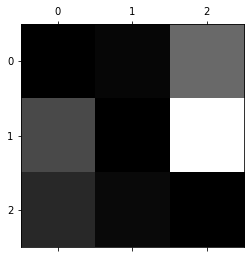

In [11]:
y_pred_cv = cross_val_predict(grid_search_lgb.best_estimator_, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Notes:
Best parameters based on CV:
1. num_leaves: 128
2. learning_rate: 0.3
3. min_data_in_leaf: 200
4. max_depth: 16

### submission creation

In [12]:
test_prep = transformation_pipeline.transform(test)
y_pred = grid_search_lgb.best_estimator_.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_lgb.csv', index=False)

## 4.5 Voting Classifier

In [13]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'num_private', 'permit', 'water_quality']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=False, funder=False)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance(strategy='eucledian')),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False, dry_season=False)),
    ('drop', DropColumns(features_to_drop)),
    ('encoder', CountEncoder(handle_unknown=0))
])

class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

lgb_clf = LGBMClassifier(objective='multiclass',num_class=3, min_data_in_leaf=200, num_leaves=128, learning_rate=0.3, max_depth=16)
xgb_clf = XGBClassifier(n_jobs=-1, max_depth=20, learning_rate=0.1)
rf_clf = RandomForestClassifier(max_depth=25, n_estimators=100, n_jobs=-1)

voting_clf = VotingClassifier(estimators=[
    ('rf', rf_clf), 
    ('lgb', lgb_clf),
    ('xgb', xgb_clf)], voting='soft')

voting_clf.fit(X_prep, y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=25,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, oob_score=Fals

In [14]:
test_prep = transformation_pipeline.transform(test)
y_pred = voting_clf.predict(test_prep)

test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission_voting_soft.csv', index=False)